## Assignment 2 - Exercise 3

In [ ]:
# Imports

import numpy as np
import pandas as pd
import math
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import networkx as net
from PIL import Image


### Question 3.1

To model the system, we defined it as follows:

<img src="3.1.png" width="600" >

With:

1. $\lambda_{1}$ as the arrival rate to the first waiting queue. As it is defined as time dependent $\lambda_{1}(t+10) = \lambda_{1}(t)$ the first step later on is the thinning in order to get all arrivals with their associated interarrival time.
2. $\mu_{1} = \lambda_{2} = 200$ trip requests per hour. This will go into an Exponential in order to have the time that each car needs to wait for a trip to be assigned to them.
3. $\mu_{2} = 110$ serviced trips per hour. This will be the parameter for the Exponential of the server (service time).

Queue 1 can be modelled as M|M|1, and Queue 2 can be modelled as M|M|1|10. 

The thing to keep in mind is that if Queue 2 is full (9 cars + 1 car in server), then the cars from Queue 1 cannot go even if they have a trip assigned so in the end the service time for Queue 1 is affected by the Queue 2 performance.

#### Modelling a Non-homogenous process by Thinning Process (Rejection Sampling):

1. Define a function for $\lambda(t)$.
2. Define the simulation parameters (number of pickups, initial time)
3. Simulate until having reached the desired number of pickups. For this we compare $u \sim Uniform(0,1)$ to the interarrival time obtained through running the $\lambda(t)$ for the given t divided by 150 (upper limit for $\lambda$). If $u$ is lower then the arrival is added to the list and another iteration starts.

With this, a total of 10000 pickups were reached (desired amount).

In [6]:
# Define the arrival rate function
def lambda_t(t):
    if t < 5:
        return 40 + t * (150 - 40) / 5
    elif t < 10:
        return 150 - (t - 5) * (150 - 40) / 5
    else:
        return lambda_t(t - 10)

# Define the simulation parameters
n_pickups = 10000
t = 0  # current time
pickup_times = []  # list to store the arrival times of the pickups

# Simulation loop
while len(pickup_times) < n_pickups:
    # Generate inter-arrival time according to Poisson process with rate lambda_t(t)
    inter_arrival_time = np.random.exponential(scale=1/lambda_t(t))
    
    # Generate a random number between 0 and 1
    u = np.random.uniform()
    
    # Accept the arrival only if u is less than or equal to the arrival probability given lambda_t(t)
    if u <= lambda_t(t) / 150:
        pickup_times.append(t + inter_arrival_time)
    
    # Update current time
    t += inter_arrival_time

# Print the results
print("Total number of pickups: ", len(pickup_times))
print("Average inter-arrival time [hours per arrival]: ", np.mean(np.diff(pickup_times)))
print("Average inter-arrival time [minutes per arrival]: ", np.mean(np.diff(pickup_times))*60)
print("Average arrivals per hour: ", 1/np.mean(np.diff(pickup_times)))

Total number of pickups:  10000
Average inter-arrival time [hours per arrival]:  0.015167799480272677
Average inter-arrival time [minutes per arrival]:  0.9100679688163607
Average arrivals per hour:  65.92914162008836


#### Building the Dataframe in accordance to an Event-based System:

Assumption: first row (Arrival = 0) is the initialization and t = 0. The first arrival is occurring in row 1.

1. Have each data row be 1 arrival.
2. Associate the time obtained in the thinning process.
3. Include the times associated with the parameters for the exponentials: trip request time and service time.
4. Calculate the departure time and inter arrival time for each arrival. For the departure time we compare the departure time of the previous car with the current one and grab the max one. For the inter arrival time we just calculate the difference between arrivals.
5. Include delays: delay in queue 1, delay in queue 2. And then the associated exit times for each queue in order to calculate everything later on.

&emsp; &emsp; 5a. For the first car, all times will be given by the exponential distributions as there will be no cars ahead that could generate a delay.

&emsp; &emsp; 5b. For the 2nd to 10th car, the exit time from Queue1 can be affected if their trip request time is lower than that from the previous car.

&emsp; &emsp; 5c. For the rest, there can be another term adding up to the one from (5b) and is if the Queue2 is full and the car needs to wait after receiving the trip request.

&emsp; &emsp; 5d. For the Queue2 exit time it is just the Departure Time minus the Service Time.

&emsp; &emsp; 5e. Calculate the implied Delays for each queue given all exit times.

NOTE: All the values in the dataframe are in hours as time unit. For graphs and results, it will be stated if the unit is minutes or another one.


In [7]:
# Creation of Dataframe with each arrival and its arrival time

df = pd.DataFrame({'Arrivals':range(len(pickup_times)+1)})

df['ArrivalTime'] = float(0)

for i in range(len(pickup_times)+1):
    if i == 0:
        df.loc[i,'ArrivalTime'] = 0
    else:
        df.loc[i,'ArrivalTime'] = pickup_times[i-1]

In [8]:
# Adding Exponentials, Interarrivals and Departures

df['TripRequestTime'] = float(0)
df['ServiceTime'] = float(0)
df['DepartureTime'] = float(0)
df['InterArrivalTime'] = float(0)

for i in range(len(df)):
    if i == 0:
        df.loc[i,'TripRequestTime'] = float(0)
        df.loc[i,'ServiceTime'] = float(0)
        df.loc[i,'DepartureTime'] = float(0)
        df.loc[i,'InterArrivalTime'] = float(0)
    else:
        df.loc[i,'TripRequestTime'] = np.random.exponential(scale=1/200)
        df.loc[i,'ServiceTime'] = np.random.exponential(scale=1/110)
        df.loc[i,'DepartureTime'] = max(df.loc[i-1,'DepartureTime']+df.loc[i,'ServiceTime'],df.loc[i,'ArrivalTime']+df.loc[i,'TripRequestTime']+df.loc[i,'ServiceTime'])
        df.loc[i,'InterArrivalTime'] = df.loc[i,'ArrivalTime']-df.loc[i-1,'ArrivalTime']



In [9]:
# Calculate Delays and Queue Exit Times

df['TimeExitQueue1'] = float(0)
df['DelayQueue1'] = float(0)
df['DelayQueue2'] = float(0)

df['TimeExitQueue2'] = df['DepartureTime'] - df['ServiceTime']

for i in range(len(df)):
    if i == 0:
        df.loc[i,'TimeExitQueue1'] = float(0)
        df.loc[i,'DelayQueue1'] = float(0)
        df.loc[i,'DelayQueue2'] = float(0)
    elif i == 1:
        df.loc[i,'TimeExitQueue1'] = df.loc[i,'ArrivalTime'] + df.loc[i,'TripRequestTime']
        df.loc[i,'DelayQueue1'] = df.loc[i,'TimeExitQueue1'] - df.loc[i,'ArrivalTime']
        df.loc[i,'DelayQueue2'] = df.loc[i,'TimeExitQueue2'] - df.loc[i,'TimeExitQueue1']
    elif i>1 and i<11:
        df.loc[i,'TimeExitQueue1'] = max(df.loc[i-1,'TimeExitQueue1'],df.loc[i,'ArrivalTime'] + df.loc[i,'TripRequestTime'])
        df.loc[i,'DelayQueue1'] = df.loc[i,'TimeExitQueue1'] - df.loc[i,'ArrivalTime']
        df.loc[i,'DelayQueue2'] = df.loc[i,'TimeExitQueue2'] - df.loc[i,'TimeExitQueue1'] 
    else:
        df.loc[i,'TimeExitQueue1'] = max(df.loc[i-10,'DepartureTime'],df.loc[i-1,'TimeExitQueue1'],df.loc[i,'ArrivalTime'] + df.loc[i,'TripRequestTime'])
        df.loc[i,'DelayQueue1'] = df.loc[i,'TimeExitQueue1'] - df.loc[i,'ArrivalTime']
        df.loc[i,'DelayQueue2'] = df.loc[i,'TimeExitQueue2'] - df.loc[i,'TimeExitQueue1']

### Question 3.2 & 3.3

After running the model for 10000 pickups, we calculated additional variables in order to plot the main features.

1. Plot for Cumulative Departures and Arrivals.
2. Plotted the number of cars in the system over time.
3. Calculated the average service time (minutes per car). Plotted service time by number of arrival and also frequency.
4. Calculated the average inter-arrival time (minutes per car), equal to the value obtained from the thinning process. Plotted arrival headway by number of arrival and also frequency.

In [10]:
# 3.2 Calculate cumulative arrivals and departures

lastDepartureTime = int(np.ceil(max(df['DepartureTime'])))

#initalize system variables
numberInSystem = []
numberInLine = []
cumulativeArrivals = []
cumulativeDepartures = []

for t in range(lastDepartureTime):
    numberInSystem.append(0)
    cumulativeArrivals.append(0)
    cumulativeDepartures.append(0)
    for n in range(n_pickups-1):
        if (df.loc[n+1,'ArrivalTime']<t):
            cumulativeArrivals[t]=cumulativeArrivals[t]+1
            if (df.loc[n+1,'DepartureTime']>t):
                numberInSystem[t]=numberInSystem[t]+1
        if (df.loc[n+1,'DepartureTime']<t):
            cumulativeDepartures[t]=cumulativeDepartures[t]+1
    numberInLine.append(max([numberInSystem[t]-1,0]))

Text(0.5, 1.0, 'Cumulative Arrivals and Departures')

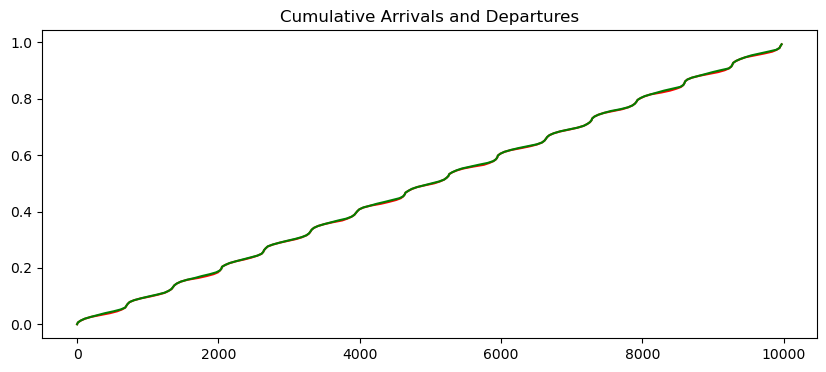

In [11]:
fig=plt.figure(figsize=(10, 4))

plt.plot(np.sort(cumulativeArrivals), np.linspace(0, 1, len(cumulativeArrivals), endpoint=False),'r')
plt.plot(np.sort(cumulativeDepartures), np.linspace(0, 1, len(cumulativeDepartures), endpoint=False),'g')
plt.title('Cumulative Arrivals and Departures')

Text(0.5, 1.0, 'Number of Cars in System over Time')

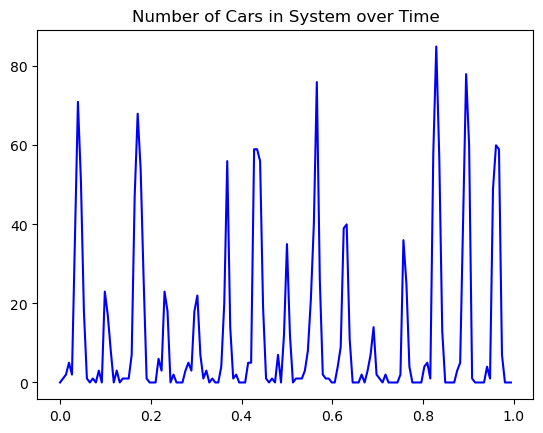

In [12]:
# 3.2 Number of users in system

plt.plot(np.linspace(0, 1, len(numberInSystem), endpoint=False),(numberInSystem),'b')
plt.title('Number of Cars in System over Time')

Average service time:  0.548  minutes


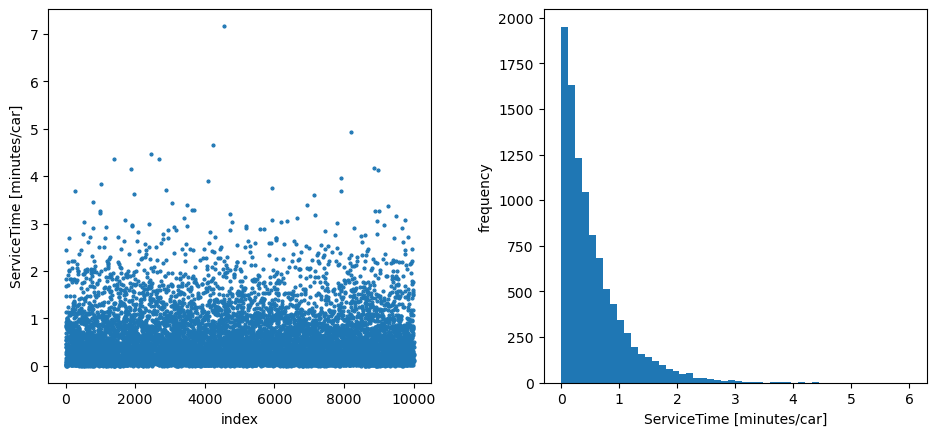

In [13]:
# 3.2 Service Time 
print('Average service time: ', round(np.average(df['ServiceTime'])*60,3), ' minutes')

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

ax1.scatter(range(len(df['ServiceTime'])), df['ServiceTime']*60, lw=2, s = 1)
ax2.hist(x=df['ServiceTime']*60, bins=50, range=[0, 6])

ax1.set(xlabel='index', ylabel='ServiceTime [minutes/car]')
ax2.set(xlabel='ServiceTime [minutes/car]', ylabel='frequency')

fig.tight_layout(pad=3.0)

### Question 3.4

To plot the waiting time histogram for each queue, we used the fields 'DelayQueueX' calculated for Question 3.1.

To plot the histogram for the total time for each queue, we used a combination of the 'TimeExitQueueX' and 'ArrivalTime'.

For Queue1 the only difference is that for the total time includes the trip request time and for the waiting time we took as if the trip request time is the 'server time'.

For Queue2, the plots should be the same as the total time in the queue is equal to the waiting time there.


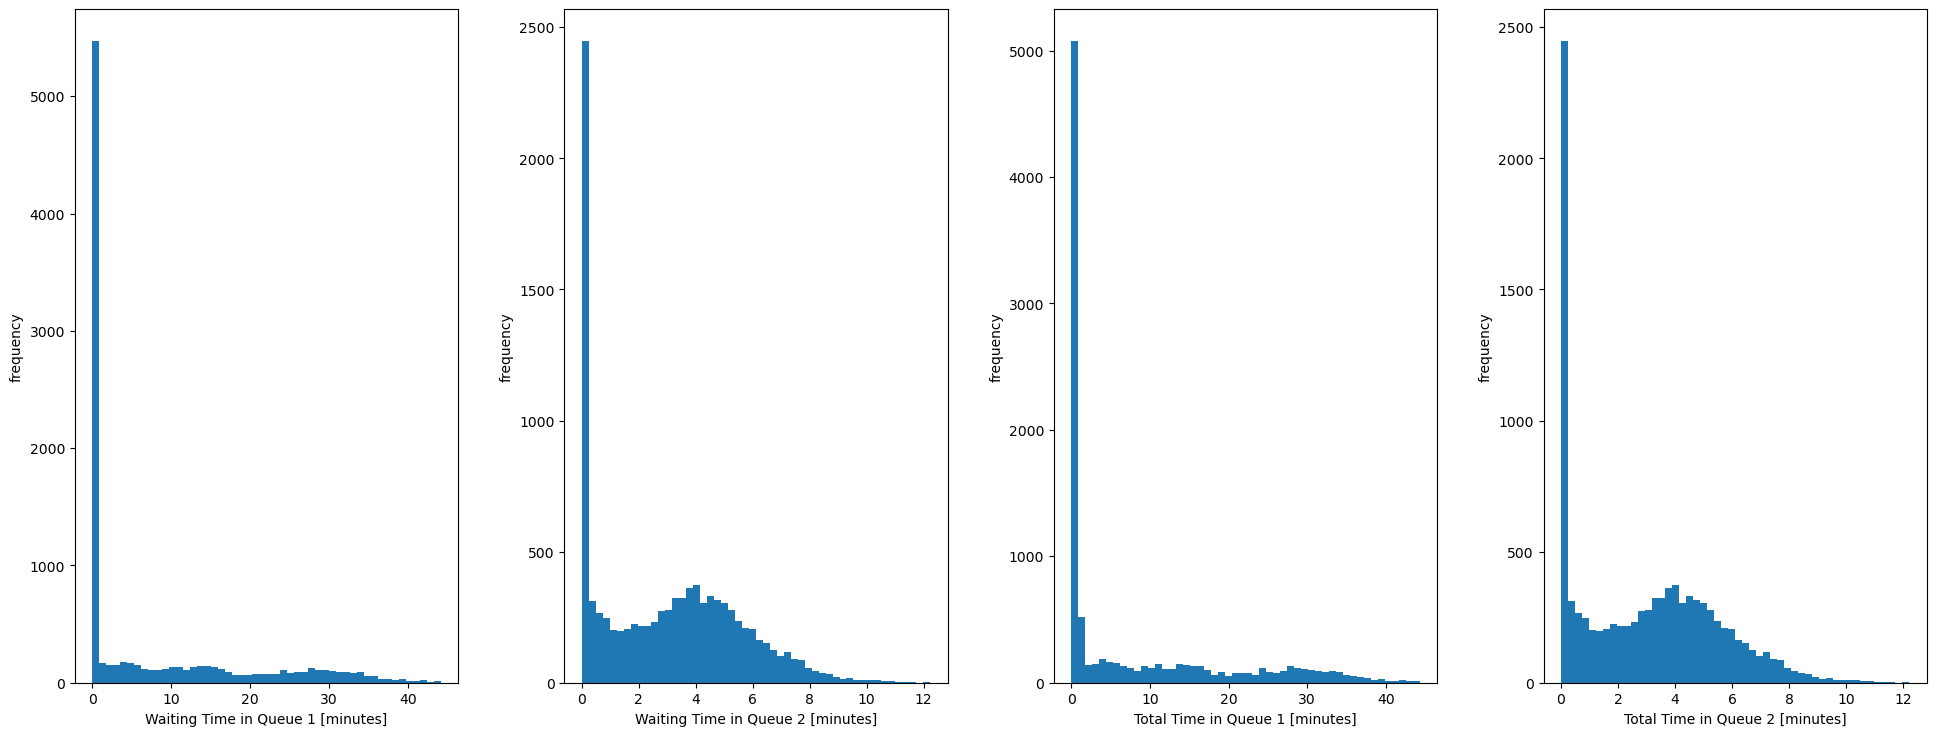

In [14]:
# 3.4 Waiting times in queues

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(20,8))

ax1.hist(x=(df['DelayQueue1']-df['TripRequestTime'])*60, bins=50)
ax2.hist(x=df['DelayQueue2']*60, bins=50)
ax3.hist(x=(df['TimeExitQueue1']-df['ArrivalTime'])*60, bins=50)
ax4.hist(x=(df['TimeExitQueue2']-df['TimeExitQueue1'])*60, bins=50)

ax1.set(xlabel='Waiting Time in Queue 1 [minutes]', ylabel='frequency')
ax2.set(xlabel='Waiting Time in Queue 2 [minutes]', ylabel='frequency')
ax3.set(xlabel='Total Time in Queue 1 [minutes]', ylabel='frequency')
ax4.set(xlabel='Total Time in Queue 2 [minutes]', ylabel='frequency')

fig.tight_layout(pad=3.0)

### Question 3.5

To calculate the results for Queue 1, we assumed that the TripRequestTime was the service time for that part of the system.

To calculate Queue 2, it is just using the exit of Queue 1 as arrivals and then the normal departures through the server.

In [15]:
# 3.5 Queue1 

print('Results for Queue 1:')

# Average T
t1 = np.average(df['TimeExitQueue1']-df['ArrivalTime'])
print('Average T is ', round(t1*60,3), ' minutes')

# Average Tq
tq1 = np.average(df['TimeExitQueue1']-df['ArrivalTime']-df['TripRequestTime'])
print('Average Tq is ', round(tq1*60,3), ' minutes')

# Average N
n1 = np.sum(df['TimeExitQueue1']-df['ArrivalTime'])/max(df['TimeExitQueue1'])
print('Average N is ', round(n1,2), ' cars')

# Average Nq
nq1 = np.sum(df['TimeExitQueue1']-df['ArrivalTime']-df['TripRequestTime'])/max(df['TimeExitQueue1'])
print('Average Nq is ', round(nq1,2), ' cars')

print('\n')
# 3.5 Queue2

print('Results for Queue 2:')

# Average T
t2 = np.average(df['DepartureTime']-df['TimeExitQueue1'])
print('Average T is ', round(t2*60,3), ' minutes')

# Average Tq
tq2 = np.average(df['DepartureTime']-df['TimeExitQueue1']-df['ServiceTime'])
print('Average Tq is ', round(tq2*60,3), ' minutes')

# Average N
n2 = np.sum(df['DepartureTime']-df['TimeExitQueue1'])/max(df['DepartureTime'])
print('Average N is ', round(n2,2), ' cars')

# Average Nq
nq2 = np.sum(df['DepartureTime']-df['TimeExitQueue1']-df['ServiceTime'])/max(df['DepartureTime'])
print('Average Nq is ', round(nq2,2), ' cars')

Results for Queue 1:
Average T is  8.158  minutes
Average Tq is  7.859  minutes
Average N is  8.95  cars
Average Nq is  8.62  cars


Results for Queue 2:
Average T is  3.48  minutes
Average Tq is  2.932  minutes
Average N is  3.82  cars
Average Nq is  3.22  cars


### Question 3.6

The T and N calculations for the entire system should be equal to the sum of the values of Queue 1 and Queue 2. However, in the global system there is only 1 service and its the server after Queue 2, that is why the Tq and Nq are different than the sum of the previous values obtained separately.

In [16]:
# 3.6 Entire system

print('Results for System:')

# Average T
t = np.average(df['DepartureTime']-df['ArrivalTime'])
print('Average T is ', round(t*60,3), ' minutes')

# Average Tq
tq = np.average(df['DepartureTime']-df['ArrivalTime']-df['ServiceTime'])
print('Average Tq is ', round(tq*60,3), ' minutes')

# Average N
n = np.sum(df['DepartureTime']-df['ArrivalTime'])/max(df['DepartureTime'])
print('Average N is ', round(n,2), ' cars')

# Average Nq
nq = np.sum(df['DepartureTime']-df['ArrivalTime']-df['ServiceTime'])/max(df['DepartureTime'])
print('Average Nq is ', round(nq,2), ' cars')

Results for System:
Average T is  11.639  minutes
Average Tq is  11.091  minutes
Average N is  12.76  cars
Average Nq is  12.16  cars


### Question 3.7

To calculate the delay time incurred in Queue 1 after receiving a trip request, we can either check the value for Tq from question 3.5 or calculate as the difference between the exit time of queue 1 and the arrival time and the trip request time.

The result is the same as Tq for Queue1.

In [17]:
# 3.7 DelayTime after receiving the trip request

dq1 = np.average(df['TimeExitQueue1']-df['ArrivalTime']-df['TripRequestTime'])

print('The delay after receiving the trip request until it leaves the Queue1 is: ', round(dq1*60,3), 'minutes')

The delay after receiving the trip request until it leaves the Queue1 is:  7.859 minutes
